# Collecting and Exploring Datasets

This repo contains code and results of my explorations of text data from different sources. The aim is to create a dataset that consists of related longer and short texts from the same source or plattform.  Longer texts are such as blog posts or news articles (full-text) and short text, should be similar in length to social media posts, such as abstracts or taglines.

**First idea: The New York Times API**  
NYT offers a set of APIs and also have one for their archive. It contains partial articles (e.g. headline, abstract) and other information, such as which section an article belongs to (e.g. Arts, News) and the length of it (word count).  
Unfortunately they only offer unlimited access to the full-texts in the [article archive](https://help.nytimes.com/hc/en-us/articles/115014772767-New-York-Times-Archived-Articles-and-TimesMachine-) for subscribed users. 

Althogh I won't be using their data for my research project, the available data is useful to find out some characteristics of news articles, e.g. the average length or how long their abstracts and titles are. This information could help in finding similar open-access data.

## Repo Structure

```bash
.
├── README.md
├── config.ini
├── data
│   ├── raw
│   └── interim
├── notebooks
│   ├── 01_nyt_apis.ipynb
│   ├── 02_guardian_api.ipynb
│   ├── 03_twitter_api.ipynb
│   └── 04_explore_datasets.ipynb
├── requirements.in
├── requirements.txt
└── src
    ├── __init__.py
    ├── data
    │   ├── __init__.py
    │   ├── clean_text.py
    │   └── make_dataset.py
    └── main.py
```

## Datasets

**NYT Dataset:**  
The dataset contains partial article data from the NYT Archive API from 10/2021 to 09/2022, approx. 34,700 items.

**GU Dataset:**  
The dataset contains article data from the GU Search API from 27/09/2021 to 27/09/2022, approx. 75,000 items.

**GU Tweets Dataset:**  
The dataset contains tweets from The Guardian main account ([@guardian](https://twitter.com/guardian)), with 3,200 items (maximum allowed number of tweets from a user as per Twitter API limitations).

In [77]:
import os
import json
import glob
import numpy as np
import pandas as pd
import re

from itertools import chain

import matplotlib.pyplot as plt
import seaborn as sns

# Notebook settings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set data directory paths
nyt_path = 'data/interim/nyt_data'
gu_path = 'data/interim/gu_data'
gu_twitter_path = 'data/interim/gu_twitter_data/gu_tweets.csv'

In [14]:
# Load NYT data files and combine them
nyt_files = glob.glob(os.path.join(nyt_path, '*.csv'))
nyt_lst = []

for file in nyt_files:
    nyt_single_df = pd.read_csv(file)
    nyt_lst.append(nyt_single_df)

nyt_df = pd.concat(nyt_lst)

In [3]:
# Load GU data files and combine them
gu_files = glob.glob(os.path.join(gu_path, '*.csv'))
gu_lst = []

for file in gu_files:
    gu_single_df = pd.read_csv(file)
    gu_lst.append(gu_single_df)

gu_df = pd.concat(gu_lst)

In [34]:
# Load GU Twitter data
twitter_df = pd.read_csv(gu_twitter_path)

### The New York Times

In [26]:
nyt_df.describe()

,word_count,word_count_headline,word_count_abstract
count,34752.000000,34752.000000,34752.000000
mean,991.256417,9.483943,22.524660
std,698.379953,2.946029,7.412678
min,0.000000,1.000000,1.000000
25%,525.000000,8.000000,18.000000
50%,934.000000,10.000000,23.000000
75%,1315.000000,11.000000,27.000000
max,20573.000000,22.000000,103.000000


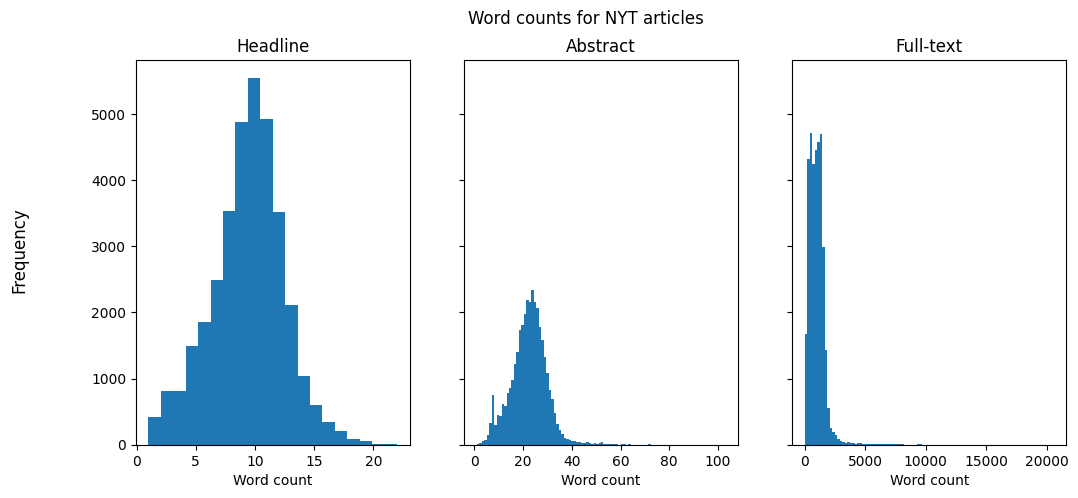

In [43]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12,5))
fig.suptitle('Word counts for NYT articles')
fig.supylabel('Frequency')

ax1.hist(nyt_df['word_count_headline'], bins=20)
ax1.set_title('Headline')
ax2.hist(nyt_df['word_count_abstract'], bins=100)
ax2.set_title('Abstract')
ax3.hist(nyt_df['word_count'], bins=100)
ax3.set_title('Full-text')

for ax in (ax1, ax2, ax3):
    ax.set(xlabel='Word count')

plt.show()

### The Guardian

In [4]:
gu_df.describe()

,wordcount,charCount,word_count_headline,word_count_trailText
count,74956.000000,74956.000000,74956.000000,74956.000000
mean,780.012301,4644.333662,11.643658,19.906385
std,464.920930,2726.342686,2.943087,5.498631
min,0.000000,0.000000,2.000000,1.000000
25%,498.000000,2980.000000,10.000000,16.000000
50%,711.000000,4239.000000,12.000000,19.000000
75%,947.000000,5654.000000,13.000000,23.000000
max,9633.000000,54826.000000,28.000000,77.000000


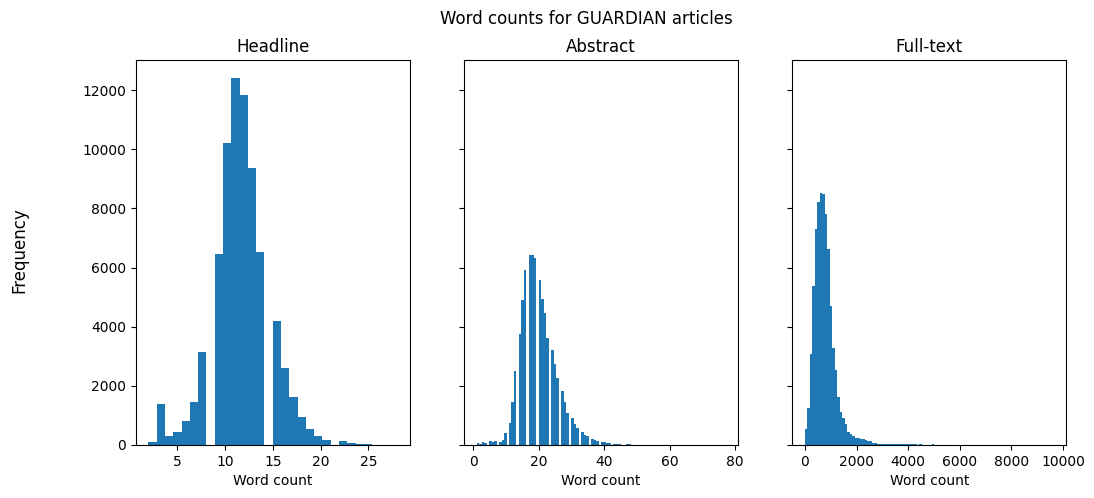

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12,5))
fig.suptitle('Word counts for GUARDIAN articles')
fig.supylabel('Frequency')

ax1.hist(gu_df['word_count_headline'], bins=30)
ax1.set_title('Headline')
ax2.hist(gu_df['word_count_trailText'], bins=100)
ax2.set_title('Abstract')
ax3.hist(gu_df['wordcount'], bins=100)
ax3.set_title('Full-text')

for ax in (ax1, ax2, ax3):
    ax.set(xlabel='Word count')

plt.show()

### Tweets from The Guardian

In [35]:
twitter_df.head()

,created_at,id,text,clean_text,word_count
0,Wed Sep 28 21:17:47 +0000 2022,1575233331943309339,Morning mail: hurricane with 240km/h winds hit...,Morning mail hurricane with kmh winds hits Flo...,14
1,Wed Sep 28 21:17:46 +0000 2022,1575233327329574924,"R Kelly ordered to pay restitution of $300,000...",R Kelly ordered to pay restitution of to his v...,10
2,Wed Sep 28 21:17:44 +0000 2022,1575233321063292928,Two aircraft involved in ‘minor collision’ on ...,Two aircraft involved in ‘minor collision’ on ...,10
3,Wed Sep 28 21:10:00 +0000 2022,1575231372490309658,We’re keen to hear from people who have recent...,We’re keen to hear from people who have recent...,25
4,Wed Sep 28 21:03:05 +0000 2022,1575229631912869894,"Guardian front page, Thursday 29 September 202...",Guardian front page Thursday September Banks £...,12


In [36]:
twitter_df.describe()

,id,word_count
count,3.200000e+03,3200.000000
mean,1.572793e+18,12.177188
std,1.462916e+15,3.107159
min,1.570134e+18,1.000000
25%,1.571554e+18,10.000000
50%,1.572913e+18,12.000000
75%,1.574037e+18,14.000000
max,1.575233e+18,25.000000


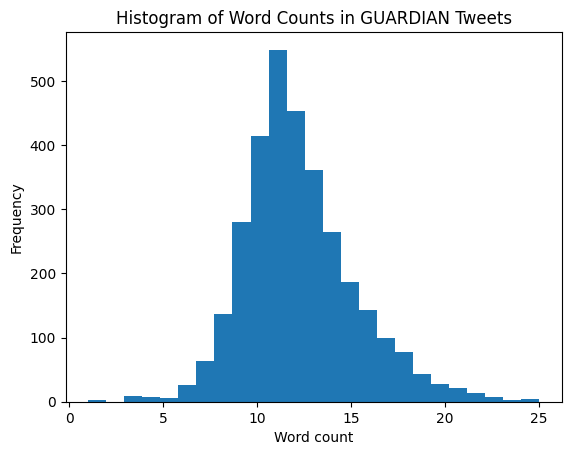

In [46]:
plt.hist(twitter_df['word_count'], bins=25)
plt.xlabel('Word count')
plt.ylabel('Frequency')
plt.title('Histogram of Word Counts in GUARDIAN Tweets')
plt.show()

---

# The Guardian Dataset Features

In [6]:
gu_df.head()

,id,sectionId,sectionName,webPublicationDate,webUrl,apiUrl,pillarId,pillarName,byline,body,...,bylineHtml,fields.contributorBio,scheduledPublicationDate,tag_ids,tag_webTitles,tag_webUrls,cl_headline,cl_trailText,word_count_headline,word_count_trailText
0,sport/blog/2022/jun/27/imperious-nsw-seize-adv...,sport,Sport,2022-06-26T23:46:44Z,https://www.theguardian.com/sport/blog/2022/ju...,https://content.guardianapis.com/sport/blog/20...,pillar/sport,Sport,Nick Tedeschi,<p>A star was born in debutant Matt Burton. An...,...,"<a href=""profile/nick-tedeschi"">Nick Tedeschi</a>",NaN,NaN,"['sport/state-of-origin', 'sport/rugbyleague',...","['State of Origin', 'Rugby league', 'NRL', 'Au...",['https://www.theguardian.com/sport/state-of-o...,Imperious NSW seize advantage after Queensland...,Poor tackling basic handling errors and a lack...,10,23
1,music/2022/jun/27/kendrick-lamar-at-glastonbur...,music,Music,2022-06-26T23:32:10Z,https://www.theguardian.com/music/2022/jun/27/...,https://content.guardianapis.com/music/2022/ju...,pillar/arts,Arts,Alexis Petridis,"<p>As Glastonbury 2022 draws to a close, a var...",...,"<a href=""profile/alexispetridis"">Alexis Petrid...",NaN,NaN,"['music/glastonbury-2022', 'music/kendrick-lam...","['Glastonbury 2022', 'Kendrick Lamar', 'Music'...",['https://www.theguardian.com/music/glastonbur...,Kendrick Lamar at Glastonbury review – faith f...,Sporting a bejewelled crown of thorns and with...,11,25
2,world/2022/jun/27/garbage-island-no-more-how-o...,world,World news,2022-06-26T23:06:58Z,https://www.theguardian.com/world/2022/jun/27/...,https://content.guardianapis.com/world/2022/ju...,pillar/news,News,Justin McCurry on Teshima island,<p>Toru Ishii remembers when the shredded car ...,...,"<a href=""profile/justinmccurry"">Justin McCurry...",NaN,NaN,"['world/japan', 'world/asia-pacific', 'world/w...","['Japan', 'Asia Pacific', 'World news', 'Envir...","['https://www.theguardian.com/world/japan', 'h...",Garbage island no more how one Japanese commun...,Teshima – site of Japan’s worst case of illega...,14,27
3,media/2022/jun/27/young-people-must-report-har...,media,Media,2022-06-26T23:01:00Z,https://www.theguardian.com/media/2022/jun/27/...,https://content.guardianapis.com/media/2022/ju...,pillar/news,News,Dan Milmo,<p>Young people should report harmful online c...,...,"<a href=""profile/danmilmo"">Dan Milmo</a>",NaN,NaN,"['media/ofcom', 'media/social-media', 'society...","['Ofcom', 'Social media', 'Online abuse', 'You...","['https://www.theguardian.com/media/ofcom', 'h...",Young people must report harmful online conten...,Ofcom says of to yearolds have seen harmful co...,10,16
4,stage/2022/jun/27/mad-house-review-david-harbo...,stage,Stage,2022-06-26T23:01:00Z,https://www.theguardian.com/stage/2022/jun/27/...,https://content.guardianapis.com/stage/2022/ju...,pillar/arts,Arts,Arifa Akbar,<p>Theresa Rebeck’s play opens as a dysfunctio...,...,"<a href=""profile/arifa-akbar"">Arifa Akbar</a>",NaN,NaN,"['stage/theatre', 'stage/stage', 'culture/cult...","['Theatre', 'Stage', 'Culture', 'Article', 'Re...","['https://www.theguardian.com/stage/theatre', ...",Mad House review – David Harbour and Bill Pull...,Theresa Rebeck’s play follows the relationship...,14,16


In [9]:
gu_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74956 entries, 0 to 6145
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        74956 non-null  object
 1   sectionId                 74956 non-null  object
 2   sectionName               74956 non-null  object
 3   webPublicationDate        74956 non-null  object
 4   webUrl                    74956 non-null  object
 5   apiUrl                    74956 non-null  object
 6   pillarId                  74453 non-null  object
 7   pillarName                74453 non-null  object
 8   byline                    73447 non-null  object
 9   body                      74956 non-null  object
 10  wordcount                 74956 non-null  int64 
 11  publication               74956 non-null  object
 12  lang                      74956 non-null  object
 13  bodyText                  74757 non-null  object
 14  charCount              

The NYT has more longer articles than the GU. The headlines show the opposite behaviour. The abstracts seem similar in both.  
Compared to the length of tweets, the most similar article part in length is the headline.

In [153]:
# Check for duplicates
gu_df[gu_df.duplicated(['id','webUrl'], keep=False)]

,id,sectionId,sectionName,webPublicationDate,webUrl,apiUrl,pillarId,pillarName,byline,body,...,bylineHtml,fields.contributorBio,scheduledPublicationDate,tag_ids,tag_webTitles,tag_webUrls,cl_headline,cl_trailText,word_count_headline,word_count_trailText
4912,lifeandstyle/2022/sep/05/work-therapy-can-a-so...,lifeandstyle,Life and style,2022-09-04T17:30:03Z,https://www.theguardian.com/lifeandstyle/2022/...,https://content.guardianapis.com/lifeandstyle/...,pillar/lifestyle,Lifestyle,Jenny Valentish,<p>Whether you’re a quiet quitter or a 24/7 si...,...,"<a href=""profile/jenny-valentish"">Jenny Valent...",NaN,NaN,"['lifeandstyle/australian-lifestyle', 'music/a...","[Australian lifestyle, Australian music, Artic...",['https://www.theguardian.com/lifeandstyle/aus...,Work therapy can a social media coach talk a s...,Musician Dave McCormack hates social media but...,15,27
4913,lifeandstyle/2022/sep/05/work-therapy-can-a-so...,lifeandstyle,Life and style,2022-09-04T17:30:03Z,https://www.theguardian.com/lifeandstyle/2022/...,https://content.guardianapis.com/lifeandstyle/...,pillar/lifestyle,Lifestyle,Jenny Valentish,<p>Whether you’re a quiet quitter or a 24/7 si...,...,"<a href=""profile/jenny-valentish"">Jenny Valent...",NaN,NaN,"['lifeandstyle/australian-lifestyle', 'music/a...","[Australian lifestyle, Australian music, Artic...",['https://www.theguardian.com/lifeandstyle/aus...,Work therapy can a social media coach talk a s...,Musician Dave McCormack hates social media but...,15,27
1247,film/2022/aug/21/anais-in-love-review-anais-de...,film,Film,2022-08-21T07:00:02Z,https://www.theguardian.com/film/2022/aug/21/a...,https://content.guardianapis.com/film/2022/aug...,pillar/arts,Arts,Wendy Ide,"<p>She’s a familiar character. Skittish, self-...",...,"<a href=""profile/wendy-ide"">Wendy Ide</a>",NaN,NaN,"['film/drama', 'film/film', 'culture/culture',...","[Drama films, Film, Culture, World cinema, Art...","['https://www.theguardian.com/film/drama', 'ht...",Anaïs in Love review – Anaïs Demoustier intoxi...,Cinema’s latest irresistible chaotic femme Dem...,13,16
1248,lifeandstyle/2022/aug/21/emma-beddington-my-ki...,lifeandstyle,Life and style,2022-08-21T07:00:02Z,https://www.theguardian.com/lifeandstyle/2022/...,https://content.guardianapis.com/lifeandstyle/...,pillar/lifestyle,Lifestyle,Emma Beddington,<p>I’m nearly an empty nester. That conjures u...,...,"<a href=""profile/emma-beddington"">Emma Bedding...",NaN,NaN,"['lifeandstyle/parents-and-parenting', 'lifean...","[Parents and parenting, Family, Life and style...",['https://www.theguardian.com/lifeandstyle/par...,My kids have moved out but please don’t call i...,I want to take issue with this nests metaphor ...,13,19
1249,film/2022/aug/21/anais-in-love-review-anais-de...,film,Film,2022-08-21T07:00:02Z,https://www.theguardian.com/film/2022/aug/21/a...,https://content.guardianapis.com/film/2022/aug...,pillar/arts,Arts,Wendy Ide,"<p>She’s a familiar character. Skittish, self-...",...,"<a href=""profile/wendy-ide"">Wendy Ide</a>",NaN,NaN,"['film/drama', 'film/film', 'culture/culture',...","[Drama films, Film, Culture, World cinema, Art...","['https://www.theguardian.com/film/drama', 'ht...",Anaïs in Love review – Anaïs Demoustier intoxi...,Cinema’s latest irresistible chaotic femme Dem...,13,16
1250,lifeandstyle/2022/aug/21/emma-beddington-my-ki...,lifeandstyle,Life and style,2022-08-21T07:00:02Z,https://www.theguardian.com/lifeandstyle/2022/...,https://content.guardianapis.com/lifeandstyle/...,pillar/lifestyle,Lifestyle,Emma Beddington,<p>I’m nearly an empty nester. That conjures u...,...,"<a href=""profile/emma-beddington"">Emma Bedding...",NaN,NaN,"['lifeandstyle/parents-and-parenting', 'lifean...","[Parents and parenting, Family, Life and style...",['https://www.theguardian.com/lifeandstyle/par...,My kids have moved out but please don’t call i...,I want to take issue with this nests metaphor ...,13,19
1390,world/2022/aug/20/estonia-europe-inflation-hot...,world,World news,2022-08-20T07

In [154]:
# Drop duplicates
gu_df.drop_duplicates(['id', 'webUrl'], keep='first', inplace=True, ignore_index=True)

## Articles per Category/Section in The Guardian

Number of articles per section

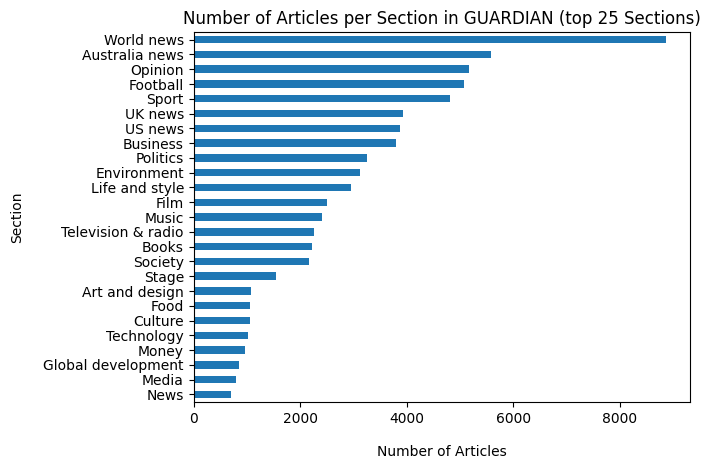

In [156]:
gu_df['sectionName'].value_counts().nlargest(25).sort_values(ascending=True).plot(kind='barh')
plt.xlabel("Number of Articles", labelpad=14)
plt.ylabel("Section", labelpad=14)
plt.title("Number of Articles per Section in GUARDIAN (top 25 Sections)")
plt.show()

In [179]:
#gu_df.groupby('sectionName').size().sort_values(ascending=False)
with pd.option_context('display.max_rows', None):
    display(gu_df.groupby('sectionName').agg({'wordcount': [min, max, np.mean, np.median], 'sectionName': 'count'}) \
        .sort_values([('sectionName', 'count')], ascending=False))

wordcount        \
                                                         min   max   
sectionName                                                          
World news                                                44  6734   
Australia news                                             0  3674   
Opinion                                                    0  3652   
Football                                                   0  6284   
Sport                                                      0  6247   
UK news                                                   41  7842   
US news                                                    0  5215   
Business                                                   0  6361   
Politics                                                   0  5816   
Environment                                                0  6990   
Life and style                                             0  8000   
Film                                                      76  3949   
Music                                                     50  5751   
Television & radio                                         0  5612   
Books                                                      0  6401   
Society                                                   51  6620   
Stage                                                     38  4131   
Art and design                                            80  4959   
Food                                                       1  9633   
Culture                                                    0  5711   
Technology                                                79  4100   
Money                                                    107  4231   
Global development                                       117  6062   
Media                                                     60  6037   
News                                                      61  7824   
Education                                                 67  5699   
Science                                                   38  6769   
Travel                                                     0  5362   
Fashion                                                   68  6798   
Law                                                       94  2719   
Games                                                    167  3354   
Crosswords                                                 0  1164   
From the Observer                                        269  1605   
Guardian Masterclasses                                    30  1654   
Global                                                     0  2710   
GNM press office                                         146  1118   
Inequality                                               152  2000   
Info                                                     179  7066   
The invested generation                                  763  1376   
Cities                                                   140  1094   
Animals farmed                                           882  1112   
Seek: The new world of work                              640  1226   
Bonjour Provence and Côte d’Azur                          34  1333   
Community of solvers                                     741  1271   
Membership                                               464  2561   
Spotify: Morning moods                                   576  1364   
Weather                                                  189   815   
SBS: A world of difference                               615  1141   
A new career with The University of Law                   23  1119   
Macquarie: Home of electric vehicles                     791  1407   
On my terms                                              454   999   
Connected thinking                                       987  1520   
The Guardian clearing hub                                128  1048   
From the Guardian                                        419  2238   
A vision for better food                                 834 

In [208]:
# List of sections with more than 10 articles
greater_10_lst = gu_df.groupby('sectionName').filter(lambda x: len(x) > 10).groupby('sectionName').agg({'sectionName': 'count'}).index.tolist()

In [212]:
gu_df[gu_df['sectionName'].isin(greater_10_lst)].groupby('sectionName')['sectionName'].agg(['count']).sort_values('count', ascending=False)

,count
sectionName,
World news,8873
Australia news,5593
Opinion,5169
Football,5075
Sport,4811
UK news,3933
US news,3877
Business,3800
Politics,3263


There are a lot of sections that seem to be concerned with only one very specific topic. These also contain very few articles ($\leq$ 10).  
**'Animals farmed'** is a special series inside the environment section. It contains articleas about food production and climate issues, so it can also be considered news.  
**'Inequality'** has articles about pocilies and current political and societal issues, so it belongs to news. 

In [213]:
# Drop sections not related to 'real' news
sections_to_drop = ['Football', 'Sport', 'Life and style', 'Film', 'Music', 'Television & radio', 'Books', 'Society',
'Stage', 'Art and design', 'Food', 'Culture', 'Media', 'Travel', 'Fashion', 'Games', 'Crosswords',
'Guardian Masterclasses', 'GNM press office', 'Info', 'The invested generation', 'Cities'] 

Select only sections from news related categories that contain more than 10 items.

In [216]:
gu_news_df = gu_df[~gu_df['sectionName'].isin(sections_to_drop) & gu_df['sectionName'].isin(greater_10_lst)]

In [217]:
with pd.option_context('display.max_rows', None):
    display(gu_news_df.groupby('sectionName').agg({'wordcount': [min, max, np.mean, np.median], 'sectionName': 'count'}) \
        .sort_values([('sectionName', 'count')], ascending=False))

wordcount                          sectionName
                         min   max        mean median       count
sectionName                                                      
World news                44  6734  794.656148  706.0        8873
Australia news             0  3674  839.524584  781.0        5593
Opinion                    0  3652  859.196750  892.0        5169
UK news                   41  7842  650.519959  587.0        3933
US news                    0  5215  862.981171  785.0        3877
Business                   0  6361  663.485000  614.0        3800
Politics                   0  5816  722.032179  657.0        3263
Environment                0  6990  762.019539  682.0        3122
Technology                79  4100  753.202369  634.0        1013
Money                    107  4231  714.265979  571.0         970
Global development       117  6062  884.699408  811.0         845
News                      61  7824  503.050360  227.0         695
Education                 67  5699  648.908148  569.0         675
Science                   38  6769  702.636228  584.5         668
Law                       94  2719  730.716846  650.0         279
From the Observer        269  1605  682.702703  387.0         111
Global                     0  2710  816.560976  657.0          41
Inequality               152  2000  671.269231  614.0          26
Animals farmed           882  1112  995.272727  989.0          11

In [233]:
gu_news_df[gu_news_df['wordcount'] == 0][['body', 'bodyText']]

,body,bodyText
379,"<figure class=""element element-atom""> \n <gu-a...",NaN
556,"<figure class=""element element-interactive int...",NaN
1001,"<figure class=""element element-interactive int...",NaN
1428,"<figure class=""element element-interactive int...",NaN
2024,"<figure class=""element element-interactive int...",NaN
...,...,...
72608,"<figure class=""element element-interactive int...",NaN
73475,"<figure class=""element element-interactive int...",NaN
74057,"<figure class=""element element-interactive int...",NaN
74500,"<figure class=""element element-image element--...",NaN


Items with wordcount = 0 have some kind of HTML content that is not text.

In [231]:
print(gu_news_df[gu_news_df['wordcount'] == 0].iloc[0]['body'])
print(gu_news_df[gu_news_df['wordcount'] == 0].iloc[120]['body'])

<figure class="element element-atom"> 
 <gu-atom data-atom-id="7c5c6f4d-068a-455b-88d9-3d0274c6c70d" data-atom-type="quiz"> 
  <div>
   <div class="quiz" data-questions-length="8" data-title="The Almost Great Electricity Crisis Quiz">
    <ol class="quiz__questions">
     <li class="quiz__question question" data-text="What is load shedding?"><p class="question__text">What is load shedding?</p>
      <ol class="question__answers" type="A" data-answers-length="4">
       <li class="question__answer answer" data-text="A yoga term describing the relief when moving from the downward dog to a low lunge." data-correct="false"><p class="answer__text">A yoga term describing the relief when moving from the downward dog to a low lunge.</p></li>
       <li class="question__answer answer" data-text=" A fancy name for a blackout." data-correct="false"><p class="answer__text"> A fancy name for a blackout.</p></li>
       <li class="question__answer answer" data-text="A last resort when electricity ma

Items with 0 words contain interactive contents, like quizes and multimedia.

In [234]:
# remove rows where wordcount is 0
gu_news_df = gu_news_df[gu_news_df['wordcount'] != 0]

In [244]:
with pd.option_context('display.max_colwidth', None):
    print(gu_news_df[gu_news_df['wordcount'] == 1]['body'].to_string()[:300])

12230    <figure class="element element-atom"> \n <gu-atom data-atom-id="59f05449-081a-4cbe-a869-2341aa1c4369" data-atom-type="quiz"> \n  <div>\n   <div class="quiz" data-questions-length="25" data-title="The bumper climate quiz">\n    <ol class="quiz__questions">\n     <li class="quiz__question que


In [245]:
# remove rows where wordcount is 0
gu_news_df = gu_news_df[gu_news_df['wordcount'] != 1]

In [246]:
with pd.option_context('display.max_rows', None):
    display(gu_news_df.groupby('sectionName').agg({'wordcount': [min, max, np.mean, np.median], 'sectionName': 'count'}) \
        .sort_values([('sectionName', 'count')], ascending=False))

wordcount                          sectionName
                         min   max        mean median       count
sectionName                                                      
World news                44  6734  794.656148  706.0        8873
Australia news            80  3674  840.125425  781.0        5589
Opinion                   13  3652  881.013291  900.0        5041
UK news                   41  7842  650.519959  587.0        3933
US news                   99  5215  863.203818  785.5        3876
Business                 109  6361  663.659647  614.0        3799
Politics                  32  5816  722.253525  657.5        3262
Environment               40  6990  762.507692  682.0        3120
Technology                79  4100  753.202369  634.0        1013
Money                    107  4231  714.265979  571.0         970
Global development       117  6062  884.699408  811.0         845
News                      61  7824  503.050360  227.0         695
Education                 67  5699  648.908148  569.0         675
Science                   38  6769  702.636228  584.5         668
Law                       94  2719  730.716846  650.0         279
From the Observer        269  1605  682.702703  387.0         111
Global                    73  2710  858.435897  659.0          39
Inequality               152  2000  671.269231  614.0          26
Animals farmed           882  1112  995.272727  989.0          11

In [255]:
gu_news_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42825 entries, 2 to 74949
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        42825 non-null  object
 1   sectionId                 42825 non-null  object
 2   sectionName               42825 non-null  object
 3   webPublicationDate        42825 non-null  object
 4   webUrl                    42825 non-null  object
 5   apiUrl                    42825 non-null  object
 6   pillarId                  42775 non-null  object
 7   pillarName                42775 non-null  object
 8   byline                    42497 non-null  object
 9   body                      42825 non-null  object
 10  wordcount                 42825 non-null  int64 
 11  publication               42825 non-null  object
 12  lang                      42825 non-null  object
 13  bodyText                  42825 non-null  object
 14  charCount             

In [258]:
# drop weird columns contributorBio and scheduledPublicationDate
gu_news_df.drop(['fields.contributorBio', 'scheduledPublicationDate'], axis=1, inplace=True)

In [261]:
# reset index
gu_news_df.reset_index(drop=True, inplace=True)

Tags in all articles

In [36]:
# convert tags webTitles string into list
gu_news_df['tag_webTitles'] = gu_news_df['tag_webTitles'].apply(lambda x: x.strip('[]').replace("'", '').split(', '))

In [247]:
# create set of tags
tags_lst = []

tags_lst.extend(gu_news_df['tag_webTitles'])
print("Number of unique tags: ", len(set(list(chain.from_iterable(tags_lst)))))


Number of unique tags:  7643


In [248]:
tags_set = set(list(chain.from_iterable(tags_lst)))

In [249]:
list(tags_set)[:10]

['William Morris',
 'GDPR',
 'Khalil El Halabi',
 'Nikkei',
 'Muska Najibullah',
 'Wales',
 'Australian Open',
 'Paris climate agreement',
 'The upside',
 'Chris Riddell']

In [250]:
tag_count = pd.value_counts(np.array(list(chain.from_iterable(tags_lst))))

In [251]:
tag_count

Article                                        42825
News                                           26382
UK news                                        22981
The Guardian                                   18397
Main section                                   16733
                                               ...  
Steven Borowiec                                    1
MIT - Massachusetts Institute of Technology        1
Royal Bank of Scotland                             1
Contempt of court                                  1
Jarvis Cocker                                      1
Length: 7643, dtype: int64

In [252]:
tag_count.nlargest(25)

Article           42825
News              26382
UK news           22981
The Guardian      18397
Main section      16733
World news        11909
UK Home News       8171
Opinion            7809
Politics           7691
Australia news     6788
Features           6733
Business           6648
US news            6337
Comment            6167
Environment        5496
Europe             5325
Australia News     4808
Coronavirus        4304
UK Business        3821
US News            3637
Journal            3517
UK Foreign         3493
Ukraine            3354
Russia             3291
Conservatives      3215
dtype: int64

In [254]:
tag_count.nsmallest(25)

Rugby sevens                    1
Mary Beard                      1
Manuel Cortes                   1
Brenna Hassett                  1
James Cooray Smith              1
Alex Blasdel                    1
El Niño southern oscillation    1
Michael Hogan                   1
Dzhokhar Tsarnaev               1
Josie Dale-Jones                1
Aaliyah                         1
Peter Bengtsen                  1
Shaun Peter Qureshi             1
Chris Curtis                    1
Boston Marathon bombing         1
Neal Katyal                     1
Neelie Kroes                    1
Roderick Beaton                 1
Mark Bennister                  1
Muska Najibullah                1
Hannah Brady                    1
Paulina Velasco                 1
Hulu                            1
Spanish food and drink          1
Eve Fairbanks                   1
dtype: int64

In [96]:
from wordcloud import WordCloud

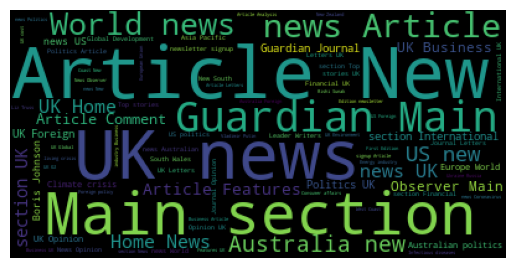

In [253]:
wordcloud = WordCloud().generate(' '.join(list(chain.from_iterable(tags_lst))))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [264]:
list(gu_news_df['sectionName'].unique())

['World news',
 'Education',
 'Australia news',
 'US news',
 'Politics',
 'News',
 'UK news',
 'Technology',
 'Opinion',
 'Global development',
 'Money',
 'Business',
 'Science',
 'From the Observer',
 'Environment',
 'Law',
 'Global',
 'Animals farmed',
 'Inequality']

Most tags are referring to sections.

In [269]:
tags_lst_unnested = list(chain.from_iterable(tags_lst))

In [271]:
tags_lst_lower = [t.lower() for t in tags_lst_unnested]

In [276]:
sections_lst = [t.lower() for t in list(gu_news_df['sectionName'].unique())]

In [280]:
tags_lst_new = [t for t in tags_lst_lower if t not in sections_lst]

In [284]:
tag_count_new = pd.value_counts(np.array(tags_lst_new))

In [285]:
tag_count_new.nlargest(25)

article                          42825
the guardian                     18397
main section                     16733
uk home news                      8171
features                          6733
comment                           6167
europe                            5325
coronavirus                       4304
uk business                       3821
journal                           3517
uk foreign                        3493
ukraine                           3354
russia                            3291
conservatives                     3215
international                     3040
society                           3005
health                            2788
the observer                      2699
letters                           2550
boris johnson                     2496
australian politics               2476
uk opinion                        2232
climate crisis                    2181
uk letters and leader writers     2169
top stories                       1960
dtype: int64

In [147]:
pillars_lst = list(gu_df['pillarName'].unique())
pillars_lst

['Sport', 'Arts', 'News', 'Opinion', 'Lifestyle', nan]

In [286]:
gu_news_df.groupby('pillarName')['pillarName'].agg(['count']).sort_values('count', ascending=False)

,count
pillarName,
News,36764
Opinion,5041
Lifestyle,970


In [287]:
gu_news_df.groupby(['pillarName', 'sectionName']).size()

pillarName  sectionName       
Lifestyle   Money                  970
News        Australia news        5589
            Business              3799
            Education              675
            Environment           3120
            From the Observer      111
            Global development     845
            Inequality              26
            Law                    279
            News                   695
            Politics              3262
            Science                668
            Technology            1013
            UK news               3933
            US news               3876
            World news            8873
Opinion     Opinion               5041
dtype: int64

In [292]:
# remove pillars Lifestyle and Opinion
gu_news_reduced_df = gu_news_df[~gu_news_df['pillarName'].isin(['Lifestyle', 'Opinion'])]
gu_news_reduced_df.reset_index(drop=True, inplace=True)

In [293]:
gu_news_reduced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36814 entries, 0 to 36813
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    36814 non-null  object
 1   sectionId             36814 non-null  object
 2   sectionName           36814 non-null  object
 3   webPublicationDate    36814 non-null  object
 4   webUrl                36814 non-null  object
 5   apiUrl                36814 non-null  object
 6   pillarId              36764 non-null  object
 7   pillarName            36764 non-null  object
 8   byline                36498 non-null  object
 9   body                  36814 non-null  object
 10  wordcount             36814 non-null  int64 
 11  publication           36814 non-null  object
 12  lang                  36814 non-null  object
 13  bodyText              36814 non-null  object
 14  charCount             36814 non-null  int64 
 15  bylineHtml            36498 non-null

In [294]:
with pd.option_context('display.max_rows', None):
    display(gu_news_reduced_df.groupby('sectionName').agg({'wordcount': [min, max, np.mean, np.median], 'sectionName': 'count'}) \
        .sort_values([('sectionName', 'count')], ascending=False))

wordcount                          sectionName
                         min   max        mean median       count
sectionName                                                      
World news                44  6734  794.656148  706.0        8873
Australia news            80  3674  840.125425  781.0        5589
UK news                   41  7842  650.519959  587.0        3933
US news                   99  5215  863.203818  785.5        3876
Business                 109  6361  663.659647  614.0        3799
Politics                  32  5816  722.253525  657.5        3262
Environment               40  6990  762.507692  682.0        3120
Technology                79  4100  753.202369  634.0        1013
Global development       117  6062  884.699408  811.0         845
News                      61  7824  503.050360  227.0         695
Education                 67  5699  648.908148  569.0         675
Science                   38  6769  702.636228  584.5         668
Law                       94  2719  730.716846  650.0         279
From the Observer        269  1605  682.702703  387.0         111
Global                    73  2710  858.435897  659.0          39
Inequality               152  2000  671.269231  614.0          26
Animals farmed           882  1112  995.272727  989.0          11

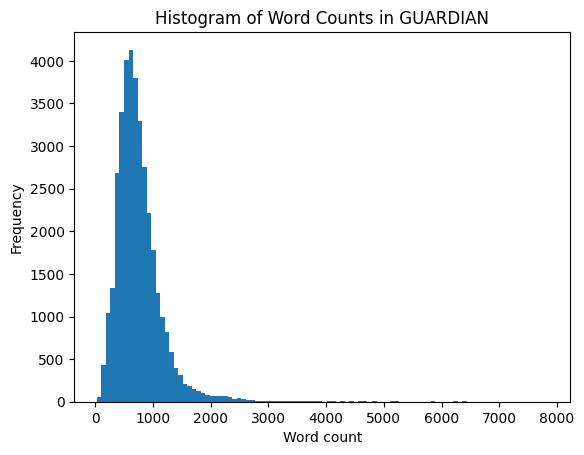

In [295]:
plt.hist(gu_news_reduced_df['wordcount'], bins=100)
plt.xlabel('Word count')
plt.ylabel('Frequency')
plt.title('Histogram of Word Counts in GUARDIAN')
plt.show()

In [321]:
gu_news_reduced_df[['sectionName', 'sectionId']]

,sectionName,sectionId
0,World news,world
1,Education,education
2,Australia news,australia-news
3,US news,us-news
4,Politics,politics
...,...,...
36809,Environment,environment
36810,World news,world
36811,Australia news,australia-news
36812,Environment,environment


### Tags in reduced dataset

In [398]:
# lowercase all tags
gu_news_reduced_df['tags'] = gu_news_reduced_df['tag_webTitles'].apply(lambda x: [t.lower() for t in x])

**article** is present in all articles' tags list

In [407]:
# remove 'article' from all tags lists
gu_news_reduced_df['tags'] = gu_news_reduced_df['tags'].apply(lambda x: [i for i in x if i != 'article'])

In [408]:
# create set of tags
tags_red_lst = []

tags_red_lst.extend(gu_news_reduced_df['tags'])
print("Number of unique tags: ", len(set(list(chain.from_iterable(tags_red_lst)))))

tag_red_count = pd.value_counts(np.array(list(chain.from_iterable(tags_red_lst))))

Number of unique tags:  6177


In [409]:
tags_red_df = tag_red_count.to_frame(name='count')

In [410]:
tags_red_df

,count
news,26023
uk news,20056
the guardian,16019
main section,15567
australia news,11199
...,...
kat george,1
danya hajjaji,1
tom hardy,1
david blanchflower,1


In [412]:
len(tags_red_df)

6177

In [426]:
# create dictionary to store wordcounts per tag
tags_wordcount_dict = dict()

for i in range(len(tags_red_df)):
    tags_wordcount_dict[tags_red_df.index[i]] = []

In [419]:
test_df = gu_news_reduced_df[['tags', 'wordcount']].iloc[:10]

In [428]:
for key, val in tags_wordcount_dict.items():
    for index, row in gu_news_reduced_df.iterrows():
        if key in row['tags']:
            tags_wordcount_dict[key].append(row['wordcount'])

In [431]:
with open('./data/interim/tags_wordcount.json', 'w') as f:
    json.dump(tags_wordcount_dict, f)

In [ ]:
tags_wordcount_dict

In [440]:
tags_red_df = tags_red_df.reindex(columns=tags_red_df.columns.tolist() + ['wordcount_min', 'wordcount_max', 'wordcount_mean', 'wordcount_median'])

In [442]:
for key, val in tags_wordcount_dict.items():
    tags_red_df['wordcount_min'][key] = np.min(val)
    tags_red_df['wordcount_max'][key] = np.max(val)
    tags_red_df['wordcount_mean'][key] = np.mean(val)
    tags_red_df['wordcount_median'][key] = np.median(val)

In [462]:
tags_red_df[tags_red_df['count'] == 1].sort_values(by='wordcount_median', ascending=True).head(25)

,count,wordcount_min,wordcount_max,wordcount_mean,wordcount_median
garry blight,1,32.0,32.0,32.0,32.0
stephen sedley,1,94.0,94.0,94.0,94.0
the thick of it,1,114.0,114.0,114.0,114.0
utopia,1,114.0,114.0,114.0,114.0
alan walker,1,115.0,115.0,115.0,115.0
newsletter sign-up,1,117.0,117.0,117.0,117.0
geoff lemon,1,117.0,117.0,117.0,117.0
the upside weekly report,1,117.0,117.0,117.0,117.0
the upside,1,117.0,117.0,117.0,117.0
richard bourne,1,132.0,132.0,132.0,132.0


In [455]:
for a in range(10):
    print(gu_news_reduced_df.sort_values(by='wordcount', ascending=True).iloc[a]['cl_headline'])
    print(gu_news_reduced_df.sort_values(by='wordcount', ascending=True).iloc[a]['wordcount'])
    print(gu_news_reduced_df.sort_values(by='wordcount', ascending=True).iloc[a]['webUrl'])
    print(gu_news_reduced_df.sort_values(by='wordcount', ascending=True).iloc[a]['sectionName'])
    print(gu_news_reduced_df.sort_values(by='wordcount', ascending=True).iloc[a]['tags'])
    print(gu_news_reduced_df.sort_values(by='wordcount', ascending=True).iloc[a]['tag_webUrls'])

Tory leadership odds tracker who do bookies favour to be the next PM
32
https://www.theguardian.com/politics/2022/jul/27/tory-leadership-latest-odds-tracker-bookies-next-pm-sunak-truss
Politics
['conservatives', 'boris johnson', 'politics', 'uk news', 'rishi sunak', 'penny mordaunt', 'liz truss', 'seán clarke', 'garry blight', 'uk visuals']
['https://www.theguardian.com/politics/conservatives', 'https://www.theguardian.com/politics/boris-johnson', 'https://www.theguardian.com/politics/politics', 'https://www.theguardian.com/uk/uk', 'https://www.theguardian.com/politics/rishi-sunak', 'https://www.theguardian.com/politics/penny-mordaunt', 'https://www.theguardian.com/politics/liz-truss', 'https://www.theguardian.com/articles', 'https://www.theguardian.com/profile/seanclarke', 'https://www.theguardian.com/profile/garry-blight', 'https://www.theguardian.com/tracking/commissioningdesk/uk-visuals']
Are there any foods that have not at some time been considered harmful in a study
38
https://w

In [457]:
gu_news_reduced_df[(gu_news_reduced_df['wordcount'] < 200) & (gu_news_reduced_df['wordcount'] > 50)][['sectionName', 'cl_headline', 'wordcount']]

,sectionName,cl_headline,wordcount
5,News,Corrections and clarifications,138
6,UK news,Firefighters tackle blaze on Edinburgh’s Calto...,192
25,Global development,Outsourcing has eroded workers’ wages and rights,177
151,News,Corrections and clarifications,191
218,UK news,Suspected foot and mouth outbreak being invest...,146
...,...,...,...
36064,Business,Tell us how are you affected by the cost of li...,179
36092,Business,Tell us how have you been affected by fuel pro...,140
36131,News,Corrections and clarifications,195
36288,Law,Criminal barristers’ pay offer in the dock,149


In [458]:
tags_red_df[tags_red_df.index.str.startswith('call')]

,count,wordcount_min,wordcount_max,wordcount_mean,wordcount_median
callout,209,103.0,1034.0,175.698565,166.0
calla wahlquist,82,369.0,2673.0,910.902439,797.5
callout-uk-pig-culling,2,456.0,623.0,539.500000,539.5
call of duty,2,488.0,913.0,700.500000,700.5
callout-ghost-flights,2,585.0,882.0,733.500000,733.5
callout-fuel-shortages,1,154.0,154.0,154.000000,154.0
callum tennant,1,505.0,505.0,505.000000,505.0
callout-coronavirus-testing,1,553.0,553.0,553.000000,553.0
callout-bulb-energy-collapse,1,888.0,888.0,888.000000,888.0
call centres,1,379.0,379.0,379.000000,379.0


In [472]:
gu_news_reduced_df.groupby('sectionName').agg({'wordcount': ['min', 'max', 'mean', 'median']})

wordcount                         
                         min   max        mean median
sectionName                                          
Animals farmed           882  1112  995.272727  989.0
Australia news            80  3674  840.125425  781.0
Business                 109  6361  663.659647  614.0
Education                 67  5699  648.908148  569.0
Environment               40  6990  762.507692  682.0
From the Observer        269  1605  682.702703  387.0
Global                    73  2710  858.435897  659.0
Global development       117  6062  884.699408  811.0
Inequality               152  2000  671.269231  614.0
Law                       94  2719  730.716846  650.0
News                      61  7824  503.050360  227.0
Politics                  32  5816  722.253525  657.5
Science                   38  6769  702.636228  584.5
Technology                79  4100  753.202369  634.0
UK news                   41  7842  650.519959  587.0
US news                   99  5215  863.203818  785.5
World news                44  6734  794.656148  706.0

### Subsetting experiments (mean & median)

In [298]:
gu_news_gt_mean = gu_news_reduced_df[gu_news_reduced_df['wordcount'] > gu_news_reduced_df['wordcount'].mean()]

In [301]:
with pd.option_context('display.max_rows', None):
    display(gu_news_gt_mean.groupby('sectionName').agg({'wordcount': [min, max, np.mean, np.median], 'sectionName': 'count'}) \
        .sort_values([('sectionName', 'count')], ascending=False))

wordcount                            sectionName
                         min   max         mean  median       count
sectionName                                                        
World news               762  6734  1136.771362   979.5        3862
Australia news           762  3674  1048.355414   971.0        2974
US news                  762  5215  1186.409316  1075.5        2018
Environment              762  6990  1149.874209   996.5        1264
Politics                 762  5816  1058.585538   952.0        1134
Business                 762  6361  1004.374645   916.0        1057
UK news                  762  7842  1091.057447   914.0         940
Global development       766  6062  1124.012448   989.0         482
Technology               762  4100  1181.345946  1084.0         370
Science                  768  6769  1416.858896  1157.0         163
Education                762  5699  1156.932886   985.0         149
News                     770  7824  1734.955752  1134.0         113
Law                      763  2719  1071.540816   954.0          98
From the Observer        906  1605  1109.980000  1101.5          50
Global                   783  2710  1471.705882  1169.0          17
Animals farmed           882  1112   995.272727   989.0          11
Inequality               798  2000  1087.625000   981.0           8

In [302]:
gu_news_gt_median = gu_news_reduced_df[gu_news_reduced_df['wordcount'] > gu_news_reduced_df['wordcount'].median()]

In [303]:
with pd.option_context('display.max_rows', None):
    display(gu_news_gt_median.groupby('sectionName').agg({'wordcount': [min, max, np.mean, np.median], 'sectionName': 'count'}) \
        .sort_values([('sectionName', 'count')], ascending=False))

wordcount                            sectionName
                         min   max         mean  median       count
sectionName                                                        
World news               684  6734  1065.276778   921.0        4668
Australia news           684  3674   983.698301   904.0        3709
US news                  684  5215  1134.255282  1024.5        2272
Environment              684  6990  1070.449098   924.0        1552
Politics                 684  5816   973.217535   879.0        1517
Business                 684  6361   923.350842   828.0        1485
UK news                  684  7842   977.526588   834.0        1354
Global development       686  6062  1060.606643   934.0         572
Technology               684  4100  1100.414254  1000.0         449
Science                  684  6769  1234.307692   936.0         221
Education                685  5699  1022.646512   877.0         215
News                     685  7824  1601.076923  1044.5         130
Law                      686  2719  1005.256198   903.0         121
From the Observer        906  1605  1109.980000  1101.5          50
Global                   714  2710  1393.105263  1074.0          19
Animals farmed           882  1112   995.272727   989.0          11
Inequality               706  2000   988.000000   928.0          11

Tags in Median-based subset

In [304]:
# create set of tags
tags_median_lst = []

tags_median_lst.extend(gu_news_gt_median['tag_webTitles'])
print("Number of unique tags: ", len(set(list(chain.from_iterable(tags_median_lst)))))

Number of unique tags:  4987


In [305]:
tag_median_count = pd.value_counts(np.array(list(chain.from_iterable(tags_median_lst))))

In [309]:
tags_median_lst_unnested = list(chain.from_iterable(tags_median_lst))
tags_median_lst_lower = [t.lower() for t in tags_median_lst_unnested]
tags_median_lst_new = [t for t in tags_median_lst_lower if t not in sections_lst]

In [312]:
tag_median_count_new = pd.value_counts(np.array(tags_median_lst_new))

In [317]:
gu_news_gt_median.shape

(18356, 23)

In [314]:
tag_median_count_new.nlargest(25)

article                18356
main section            8149
the guardian            7308
features                4969
uk home news            3026
europe                  2637
uk foreign              1984
coronavirus             1915
ukraine                 1800
russia                  1770
international           1757
australian politics     1710
the observer            1370
uk business             1320
health                  1275
top stories             1190
conservatives           1180
climate crisis          1142
society                 1117
comment                 1087
boris johnson           1002
us politics              940
observer main            930
new south wales          890
asia pacific             882
dtype: int64

In [315]:
tag_median_count_new.nsmallest(25)

photographing the pandemic                           1
sardinia holidays                                    1
north macedonia                                      1
anorexia                                             1
royal commission into defence and veteran suicide    1
methamphetamine (crystal meth)                       1
naturism                                             1
antonia juhasz                                       1
leonardo da vinci                                    1
uranus                                               1
anatomy and physiology                               1
futures                                              1
sally hayden                                         1
garbage                                              1
cobra (civil contingencies committee)                1
"schindlers list"                                    1
charles darwin                                       1
neptune                                              1
kenneth br